# Statistical Analysis Time Series

In [1]:
import os
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Load Data

There are several options to get stock data. here are some list of python package that you can use.  
1. quandl
2. yahoo finance
3. pandas_datareader

on this section we will load quandl to load the data.  

Data descriptions: 
tickers: **CHRIS/CME_GC1** 
time window: 2000-01-01 to 2018-12-31
Frequency: Monthly 

Historical Futures Prices: Gold Futures, Continuous Contract

In [2]:
import quandl

API_KEY = os.environ.get("QUANDL_KEY") # API key

In [3]:
quandl.ApiConfig.api_key = API_KEY

df = quandl.get('CHRIS/CME_GC1',         # tickers of the data that we want
#                 column_index=6,          # columns of the data that we want to get
                collapse='monthly',      # granularity of the data
                start_date='2000-01-01', # start date of the data
                end_date = '2018-12-31') # end date of the data

In [4]:
df.head()

Open   High    Low   Last  Change  Settle   Volume  \
Date                                                              
2000-01-31  284.0  284.5  282.6  283.2     NaN   283.2   2445.0   
2000-02-29  295.4  296.5  293.7  294.2     NaN   294.2  19656.0   
2000-03-31  275.5  279.8  274.5  278.4     NaN   278.4   3167.0   
2000-04-30  277.0  277.2  274.2  274.7     NaN   274.7  25399.0   
2000-05-31  272.5  272.7  271.3  271.7     NaN   271.7   3408.0   

            Previous Day Open Interest  
Date                                    
2000-01-31                      2590.0  
2000-02-29                     74069.0  
2000-03-31                      2542.0  
2000-04-30                     90090.0  
2000-05-31                      3010.0

In [5]:
df.index

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=228, freq=None)

In [6]:
df['Settle'].isnull().any()

False

Currently we will only use settle/closed value of the data to do time series analysis.  

the settle value doesn't have any missing value, so we can moving forward.

In [7]:
Y = df['Settle']

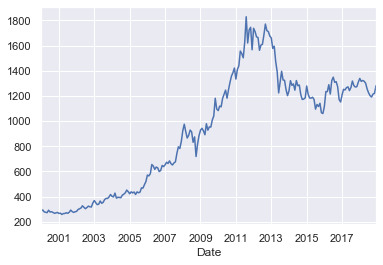

In [8]:
Y.plot();

## Split Dataset

In [9]:
Y_train = Y.loc[:'2017']
Y_valid = Y.loc['2018':] 


print(f"Train Start/End : {Y_train.index.min()}/{Y_train.index.max()}")
print(f"Valid Start/End : {Y_valid.index.min()}/{Y_valid.index.max()}")

Train Start/End : 2000-01-31 00:00:00/2017-12-31 00:00:00
Valid Start/End : 2018-01-31 00:00:00/2018-12-31 00:00:00


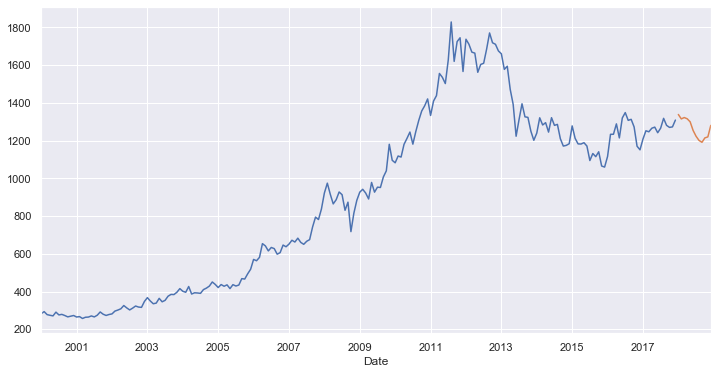

In [10]:
ax = Y_train.plot(figsize=(12, 6), label='train', sharex=True)
Y_valid.plot(ax=ax, label='valid');

## Understanding Data

### Statistic Descriptions  

first we should know the summary statistics of the data.  

often in stock market volatility is interpreted as a risk for the investors, so let's check the risk of gold price.

In [11]:
Y.describe()

count     228.000000
mean      912.862281
std       462.997818
min       257.900000
25%       421.025000
50%       964.350000
75%      1279.200000
max      1829.300000
Name: Settle, dtype: float64

Let's see the simple return of gold.

In [12]:
Y.pct_change().describe()

count    227.000000
mean       0.007849
std        0.048662
min       -0.178449
25%       -0.023439
50%        0.005920
75%        0.037769
max        0.136452
Name: Settle, dtype: float64

### Visualize the data

1. What is trend of the time series?
2. How volatile is our time series?
2. Is there any seasonality in the time series?
3. Is time series is stationary or non-stationary? 

We can see trend of time series by doing moving average and volatility by moving standard deviation.
We can also see stationarity of time series by visualizing moving average and moving standard deviation.

###### Stationarity

What does it mean for a time series to be stationary? A time series is stationary when all statistical characteristics of that series are unchanged by shifts in time.  

Weak stationarity, henceforth stationarity, requires only that:

* A series has the same finite unconditional mean and finite unconditional variance at all time periods.
* That the series autocovariances are independent of time.

> Dalam time series analysis, di asumsikan data memiliki proses yang stasioner. Jika tidak, maka data akan mungkin menghasilkan _unpredictable result_ **Spurious Regression**

###### Type of non-stationarity processes. 

* **Pure random walk** : Process with unit root or non-reverting random process.
* **Random walk with drift**: random walk with constant drift
* **Deterministic Trend** 
* **Random walk with drift and determenistic trend**

###### How to check stationarity?

* **Through Visualization**: Melihat indikasi visual dari trend, seasonality, perubahan variance yang jelas.  
* **Through Statistical Summaries**: Melihat statistic summary dari data.
* **Through Statistical Test**: Menggunakan tools statistik seperti _Augmented Dickey-Fuller Test_ apakah memenuhi kriteria stationarity.

In [13]:
Y_rolling = Y_train.rolling(12) # take the rolling 12 month (yearly)
Y_mean = Y_rolling.mean()        # see yearly moving average mean
Y_std = Y_rolling.std()          # see yearly moving average standard deviation

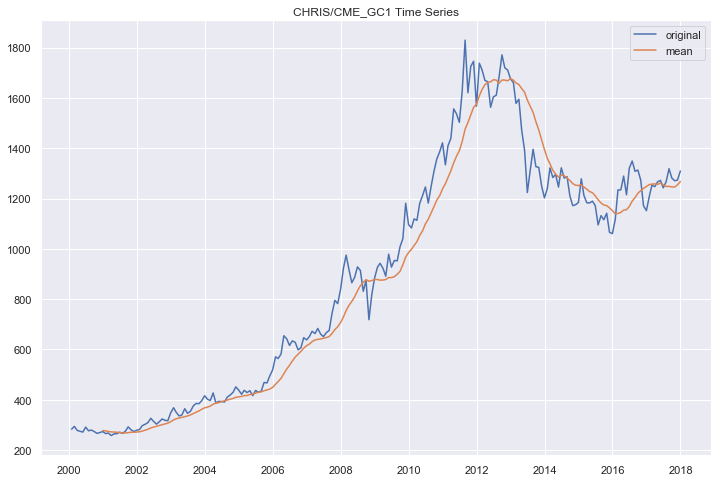

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(Y_train, label='original')
plt.plot(Y_mean, label='mean')
plt.title('CHRIS/CME_GC1 Time Series')
plt.legend()
plt.grid('both')
plt.show()

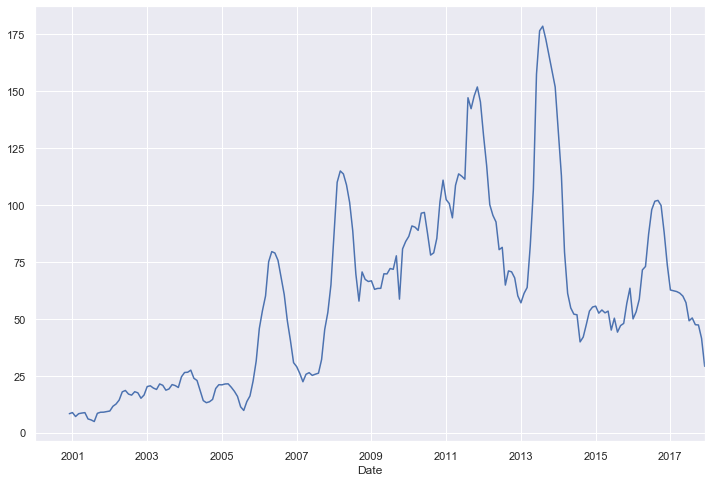

In [15]:
# plot the yearly standard deviation
Y_std.plot(figsize=(12, 8));

We can see that the standard deviation is changing overtime and also there are some trend of the time series, therefore the series is not stationary.

### Checking Stationarity by Statistical Testing

#### Adfuller

In [16]:
from statsmodels.tsa.stattools import adfuller 

# help(adfuller)

In [17]:
result = adfuller(Y_train)

print('ADF statistic: ',  result[0])
print('p-value:', result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -1.2212755888717248
p-value: 0.6643771895566182
Critical value (1%): -3.463
Critical value (5%): -2.876
Critical value (10%): -2.574


In [18]:
def adfuller_test(series, window=12, *args, **kwargs):
    
    # plot time series
    ax = series.plot(**kwargs)
    series.rolling(window=window).mean().plot(ax=ax)
    series.rolling(window=window).std().plot(ax=ax)
    
    labels = ['Test Statistic', 'P-value', 'usedlag', 'nobs']

    result = adfuller(series, *args)
    result_df = pd.DataFrame.from_records([*zip(labels, result[:4])], 
                                          columns=['type', 'value'])
    result_df.set_index('type', inplace=True)

    for k, v in result[4].items():
        result_df.loc[k] = v

    result_df.loc["IC"] = result[-1]
    
    return result_df, ax

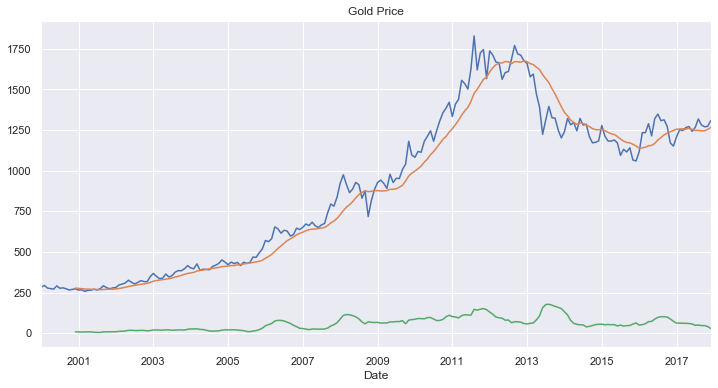

value
type                       
Test Statistic    -1.221276
P-value            0.664377
usedlag           11.000000
nobs             204.000000
1%                -3.462818
5%                -2.875815
10%               -2.574379
IC              2165.220899

In [19]:
result, ax = adfuller_test(Y_train, figsize=(12, 6))
ax.set_title('Gold Price')
plt.show()
display(result)

### Making a Time Series Stationary

### Detrending

Proses untuk menghilangkan trend dari non-stationary time-series disebut _detrending_.  

Proses ini menggunakan tahapan transformasi yang akan menormalisasi nilai yang besar menjadi kecil. contoh: Logarthmic Scaling. 

Kemudian setelah melakukan transformasi kita mengurangi hasil logarithmic tersebut dengan moving average dari 2 period.

In [20]:
import numpy as np

Y_train_log = np.log(Y_train)

In [21]:
Y_train_log_ma = Y_train_log.rolling(2).mean()
Y_train_detrend = Y_train_log - Y_train_log_ma 
Y_train_detrend.dropna(inplace=True)

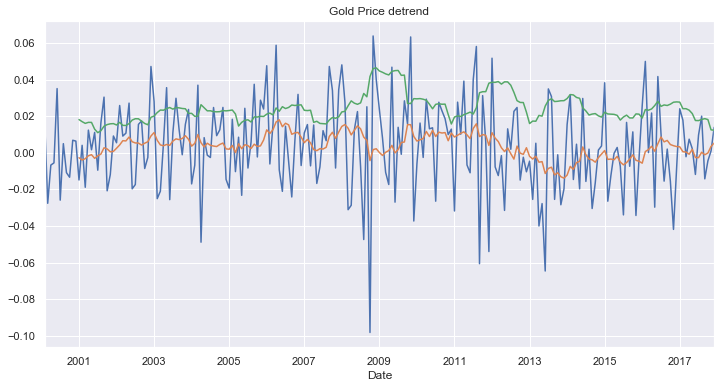

value
type                        
Test Statistic -1.673958e+01
P-value         1.361785e-29
usedlag         0.000000e+00
nobs            2.140000e+02
1%             -3.461282e+00
5%             -2.875143e+00
10%            -2.574020e+00
IC             -8.992418e+02

In [22]:
result, ax = adfuller_test(Y_train_detrend, figsize=(12, 6))
ax.set_title('Gold Price detrend')
plt.show()
display(result)

### Differencing

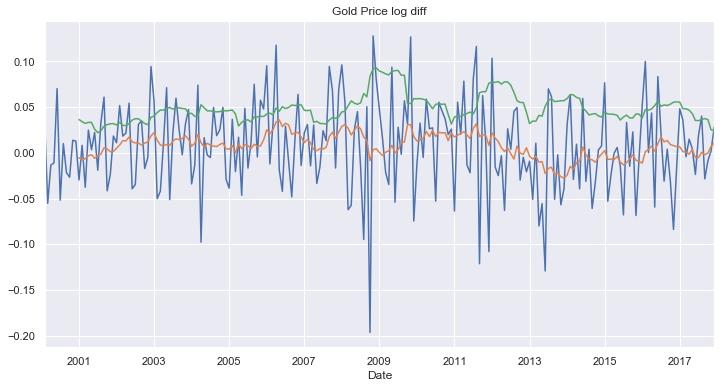

value
type                        
Test Statistic -1.673958e+01
P-value         1.361785e-29
usedlag         0.000000e+00
nobs            2.140000e+02
1%             -3.461282e+00
5%             -2.875143e+00
10%            -2.574020e+00
IC             -6.233692e+02

In [23]:
Y_train_log_diff = Y_train_log.diff(periods=1).dropna()

result, ax = adfuller_test(Y_train_log_diff, figsize=(12, 6))
ax.set_title('Gold Price log diff')
plt.show()
display(result)

In [24]:
Y_valid_log = np.log(Y_valid)

### Seasonal Decomposing

Proses decomposing melibatkan trend dan seasonal komponen, kemudian menghilangkan hal tersebut dari time series.

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose 

decompose_result = seasonal_decompose(Y_train_log.dropna(), freq=12)

df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

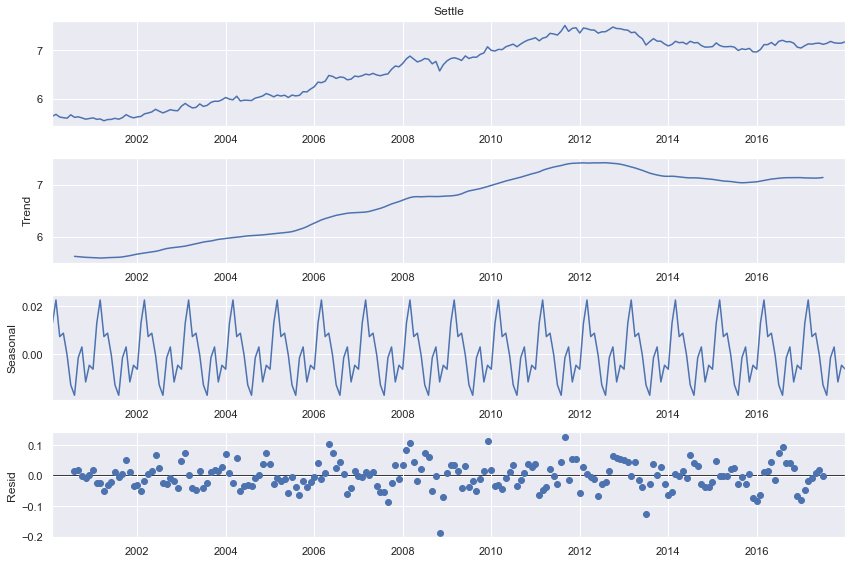

In [26]:
plt.rcParams['figure.figsize'] = (12, 8)
fig = decompose_result.plot()
plt.show()

We can see general uptrend of the time series.

### Drawbacks of ADF Testiing  

Here are some considerations when using ADF tests for reliable checking for non-stationary data:  

* the ADF test do not truly tell apart between pure and non-unit root generating processes. In long-term moving average processes. In long term moving average processes, the ADF test become biased rejecting the null hypothesis. Other stationarity testing method can be used such as **Kwiatkowsku-Philips-Schmidt-Shin (KPSS)** test and **Philips Perron** test take a different approach in treating the presence of unit roots.  
* There is no fixed methodology in determining the lag length _p_. if it is too small, the remaining serial correlation in the errors may affect the size of the test. if p is too large, the power of the test will be deteriorate. Additional consideration is to be given for this lag order.  
* As deterministic terms are added to the test regression, the power of unit root test diminished.

## Forecasting and predicting a time series

### Autoregressive Integrated Moving Average

The **Autoregressive Integrated Moving Average (ARIMA)** is a forecasting model for stationary time series data based on linear regression. As it's name suggest, it is based on three components: 

* **Autoregression (AR)**: A model that uses the dependency between an observation and its lagged value.
* **Integrated (I)**: The use of differencing an observation with an observation from previous time stamp in making the time series stationary.  
* **Moving Average (MA)**: A model that uses the dependency between an observed error term and a combination of previous error terms.

In [27]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

In [28]:
def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None 

    total_iterations = 0
    for order in param_combinations:
        for (p, d, q) in param_combinations:
            seasonal_order = (p, d, q, s)
            total_iterations += 1
            try:
                model = SARIMAX(dataframe, order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertability=False,
                                disp=False)
                model_result = model.fit(maxiter=200, disp=False)

                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order

            except Exception as ex:
                continue
        
    return lowest_aic, pdq, pdqs

In [29]:
lowest_aic, order, seasonal_order = arima_grid_search(Y_train_log, 12)

In [30]:
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA(1, 0, 0)x(0, 0, 0, 12)
Lowest AIC: -678.221


In [56]:
model = SARIMAX(Y_train_log, order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                disp=False)

model_result = model.fit(maxiter=200, disp=False)
print(model_result.summary())

                               SARIMAX Results                                
Dep. Variable:                 Settle   No. Observations:                  216
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 341.110
Date:                Sun, 04 Oct 2020   AIC                           -678.221
Time:                        12:15:13   BIC                           -671.480
Sample:                    01-31-2000   HQIC                          -675.497
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0010      0.001   1978.537      0.000       1.000       1.002
sigma2         0.0025      0.000     12.134      0.000       0.002       0.003
Ljung-Box (Q):                       49.74   Jarque-

###### Residual Diagnostics

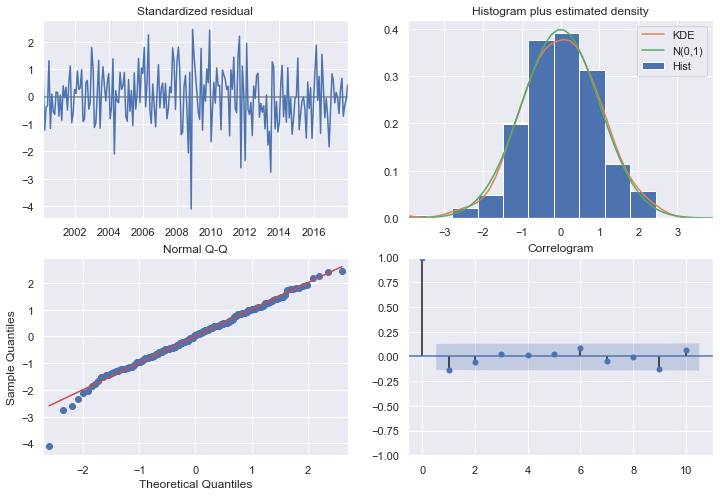

In [57]:
model_result.plot_diagnostics(figsize=(12, 8));

The top-right plot shows the kernel density estimate (KDE) of the standardized residuals, which suggests the errors are Gaussian with a mean close to zero. Let's see a more accurate statistic of the residuals:

In [58]:
model_result.resid.describe()

count    216.000000
mean       0.026610
std        0.387318
min       -0.203362
25%       -0.031042
50%        0.002888
75%        0.033852
max        5.646153
dtype: float64

### Predicting and Forecasting the SARIMAX model

#### In sample predictions

In [59]:
n = len(Y.index)

prediction = model_result.get_prediction(
                    start = 1,
                    end   = len(Y)-1,
                    typ='levels'
                )
prediction_ci = np.exp(prediction.conf_int())
prediction_value = np.exp(prediction.predicted_mean)

In [60]:
prediction_ci.head()

lower Settle  upper Settle
2000-02-29    258.469317    313.835356
2000-03-31    268.519007    326.037764
2000-04-30    254.084120    308.510817
2000-05-31    250.703916    304.406548
2000-06-30    247.963243    301.078803

#### Plot predictions result

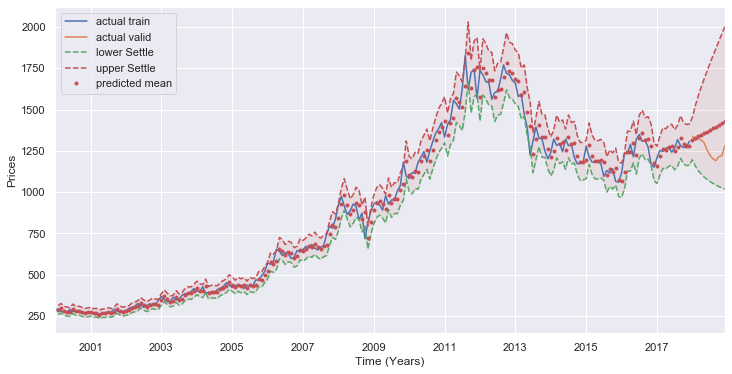

In [61]:
plt.figure(figsize=(12, 6))

ax = Y_train.plot(label='actual train')
Y_valid.plot(label='actual valid', ax=ax)
prediction_ci.plot(ax=ax, style=['--', '--'],
                   label='predicted/forecasted')

prediction_value.plot(ax=ax, color='r', style='.', label='predicted mean')
ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci, color='r', alpha=.1)
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(Y_valid, prediction_value.loc['2018':]))

134.17324194587053

#### 1-step-ahead Predictions

In [63]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.extend.html

history = Y_train.copy()
predictions = []

for t in range(len(Y_valid)):
    model_result = model_result.extend(Y_valid.iloc[[t]])
    output = model_result.get_forecast(steps=1).summary_frame()
    yhat = output
    predictions.append(yhat)

predictions = pd.concat(predictions)

In [65]:
prediction_mean = predictions['mean']
lower_ci = predictions.iloc[:, -2]
upper_ci = predictions.iloc[:, -1]

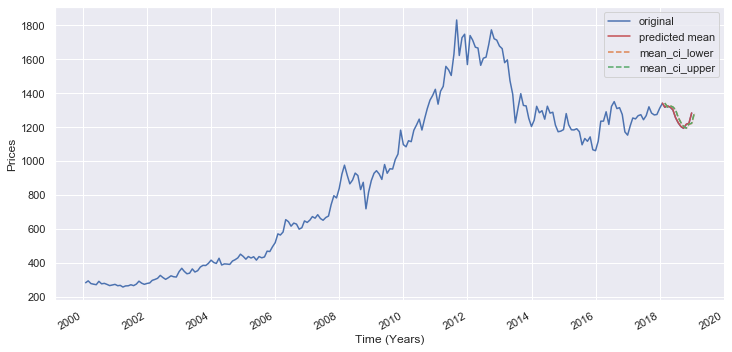

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Y.index, Y, label='original')
ax.plot(Y_valid.index, prediction_mean, color='r', label='predicted mean')
predictions[['mean_ci_lower', 'mean_ci_upper']].plot(ax=ax, style=['--', '--'],
                   label='predicted/forecasted')
ax.fill_between(prediction_mean.index, lower_ci, upper_ci, color='r', alpha=.1)
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(Y_valid, prediction_mean))

1.271354930308855

In [68]:
naive = Y_valid.shift(1).copy()
naive.iloc[0] = Y_train.iloc[-1]

np.sqrt(mean_squared_error(Y_valid, naive))

28.462431378924727

## Facebook Prophet Forecasting

In [69]:
from fbprophet import Prophet

In [70]:
fb_train = Y_train.reset_index()
fb_valid = Y_valid.reset_index()
fb_train.columns = fb_valid.columns = ["ds", "y"]
fb_train.head()

ds      y
0 2000-01-31  283.2
1 2000-02-29  294.2
2 2000-03-31  278.4
3 2000-04-30  274.7
4 2000-05-31  271.7

In [71]:
m = Prophet()
m.fit(fb_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
future = m.make_future_dataframe(periods=len(fb_valid), freq="M", include_history=True)

In [73]:
forecast = m.predict(future)
forecast.tail()

ds        trend  yhat_lower   yhat_upper  trend_lower  \
223 2018-08-31  1117.958601  994.707437  1249.562141  1111.975994   
224 2018-09-30  1112.663189  956.297593  1206.773955  1105.380655   
225 2018-10-31  1107.191263  967.236370  1219.835371  1098.289080   
226 2018-11-30  1101.895851  956.294601  1219.820193  1090.783387   
227 2018-12-31  1096.423926  937.864145  1187.442953  1083.379891   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
223  1126.217479       -2.150535             -2.150535             -2.150535   
224  1122.937429      -26.642468            -26.642468            -26.642468   
225  1119.804767      -15.942521            -15.942521            -15.942521   
226  1116.524899      -18.412935            -18.412935            -18.412935   
227  1113.427931      -32.149930            -32.149930            -32.149930   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
223  -2.150535     -2.150535     -2.150535                   0.0   
224 -26.642468    -26.642468    -26.642468                   0.0   
225 -15.942521    -15.942521    -15.942521                   0.0   
226 -18.412935    -18.412935    -18.412935                   0.0   
227 -32.149930    -32.149930    -32.149930                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
223                         0.0                         0.0  1115.808066  
224                         0.0                         0.0  1086.020721  
225                         0.0                         0.0  1091.248742  
226                         0.0                         0.0  1083.482916  
227                         0.0                         0.0  1064.273996

In [74]:
m.plot_components(forecast);

In [75]:
forecast.set_index('ds', inplace=True)

In [76]:
plt.figure(figsize=(12, 6))

ax = Y_train.plot(label='actual train')
Y_valid.plot(label='actual valid', ax=ax)
forecast[['yhat_lower', 'yhat_upper']].plot(ax=ax, 
                   style=['--', '--'],
                   label='predicted/forecasted')
forecast['yhat'].plot(ax=ax, color='r', style='.', label='predicted mean')
ci_index = forecast.index
lower_ci = forecast.loc[:, 'yhat_lower']
upper_ci = forecast.loc[:, 'yhat_upper']

ax.fill_between(ci_index, lower_ci, upper_ci, color='r', alpha=.1)
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show();

In [77]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(Y_valid, forecast.loc['2018':, 'yhat']))

164.82324128340676

# Hands On - Stock Market

## Problem Definitions  

In this case study, we want to know the potential/forecasted of future price of microsoft stock.  

1. What is their fundamental? Market condition of that industry?
2. What is their correlated asset?  
3. What is their performance in the past?   
4. Do you want to know just the price will go up or go down in the following weeks or want to know the potential price?
5. How many week ahead we need to forecast?

for the purpose of this study we will ignore correlated asset, fundamentals and other factor that can impact google stock, **which is obviously not true** but it will be easier to implement time-series analysis. We will also assume that the behaviour of the market will stay still from the historical data or not major changes.  

What can we do? 
1. With the following problem & assumption we can do time series forecasting. the method that can be used are:
    - ARIMA
    - SARIMAX 
    - Facebook Prophet
2. Let's say we only want to know 1-step-ahead or 1 week in the future    
    
In this study we will only focus on ARIMA & facebook prophet.

## Import Library

In [78]:
# data utilization & basic tools
import os 
import numpy as np
import pandas as pd
from pprint import pprint
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# financial data API
import quandl
import yfinance as yf

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# time-series modeling tools
from fbprophet import Prophet
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax 

# time-series tools & visualization
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.stats.diagnostic import acorr_ljungbox

# metrics evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Load Data  

Time window that will be used in this case study is from 2010 to 2018
**Data Collection** will be done via yahoo finance API. 

more about yahoo finance: 
- [pypi](https://pypi.org/project/yfinance/)  
- [python-yahoofinance.readthedocs.io/](https://python-yahoofinance.readthedocs.io/en/latest/api.html)

Let's define the tickers, start date and end date

In [79]:
ticker = 'MSFT'
start_date = '2010-01-01'
end_date = '2019-12-31'

In [80]:
import yfinance as yf

msft = yf.download(ticker, 
                start=start_date, 
                end=end_date,
                adjusted=True        
)

msft.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2009-12-31  30.980000  30.990000  30.480000  30.480000  23.801456  31929700
2010-01-04  30.620001  31.100000  30.590000  30.950001  24.168472  38409100
2010-01-05  30.850000  31.100000  30.639999  30.959999  24.176279  49749600
2010-01-06  30.879999  31.080000  30.520000  30.770000  24.027906  58182400
2010-01-07  30.629999  30.700001  30.190001  30.450001  23.778025  50559700

Here we have fetched several informations about google stock price. 
There are: 
1. Open
2. High
3. Low
4. Close
5. Adj Close
6. Volume

In this case we will only use adjusted closed.

## Preprocessing

Since our problem need to know the potential on the following weeks, **we can resample our data to weekly**, it will also **reduce the noise and complexity** of our time-series problem.

In [81]:
msft = msft.resample('W').last()\
                     .rename(columns={'Adj Close': 'MSFT'})\
                     .MSFT # take only adjusted close

Let's take a peek of our last data

In [82]:
dataset = msft
dataset.head()

Date
2010-01-03    23.801456
2010-01-10    23.942017
2010-01-17    24.098186
2010-01-24    22.614508
2010-01-31    22.005415
Freq: W-SUN, Name: MSFT, dtype: float64

In [83]:
Y = dataset

## Split Dataset

In [84]:
nvalid = 54
ntrain = len(Y) - nvalid

Y_train = Y.iloc[:ntrain]
Y_valid = Y.iloc[ntrain:] 

print(f"Train Start/End : {Y_train.index.min()}/{Y_train.index.max()}")
print(f"Valid Start/End : {Y_valid.index.min()}/{Y_valid.index.max()}")

Train Start/End : 2010-01-03 00:00:00/2018-12-23 00:00:00
Valid Start/End : 2018-12-30 00:00:00/2020-01-05 00:00:00


## Data Understanding

### Summary Statistics

In [85]:
dataset.describe().T

count    523.000000
mean      52.255821
std       35.247697
min       18.338606
25%       24.183289
50%       39.932461
75%       67.992680
max      157.705505
Name: MSFT, dtype: float64

### Visualize the data

1. What is trend of the time series?
2. How volatile is our time series?
2. Is there any seasonality in the time series?
3. Is time series is stationary or non-stationary? 

We can see trend of time series by doing moving average and volatility by moving standard deviation.
We can also see stationarity of time series by visualizing moving average and moving standard deviation.

###### Stationarity

What does it mean for a time series to be stationary? A time series is stationary when all statistical characteristics of that series are unchanged by shifts in time.  

Weak stationarity, henceforth stationarity, requires only that:

* A series has the same finite unconditional mean and finite unconditional variance at all time periods.
* That the series autocovariances are independent of time.

> Dalam time series analysis, di asumsikan data memiliki proses yang stasioner. Jika tidak, maka data akan mungkin menghasilkan _unpredictable result_ **Spurious Regression**

###### Type of non-stationarity processes. 

* **Pure random walk** : Process with unit root or non-reverting random process.
* **Random walk with drift**: random walk with constant drift
* **Deterministic Trend** 
* **Random walk with drift and determenistic trend**

###### How to check stationarity?

* **Through Visualization**: Melihat indikasi visual dari trend, seasonality, perubahan variance yang jelas.  
* **Through Statistical Summaries**: Melihat statistic summary dari data.
* **Through Statistical Test**: Menggunakan tools statistik seperti _Augmented Dickey-Fuller Test_ apakah memenuhi kriteria stationarity.

Let's take a look first of our time series

**Microsoft Stock Price**

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Y.index, Y.values)
ax.set_title(ticker)
ax.set_xlabel('time')
ax.set_ylabel('value');

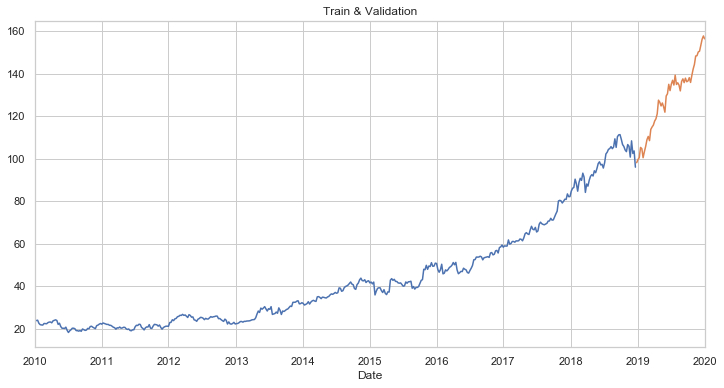

In [87]:
fig, ax = plt.subplots(figsize=(12, 6))
Y_train.plot(title="Train & Validation", label = "Train", ax=ax)
Y_valid.plot(label='valid', ax=ax);

In [88]:
msft_rolling = Y_train.rolling(52)
msft_mean = msft_rolling.mean()
msft_std = msft_rolling.std()

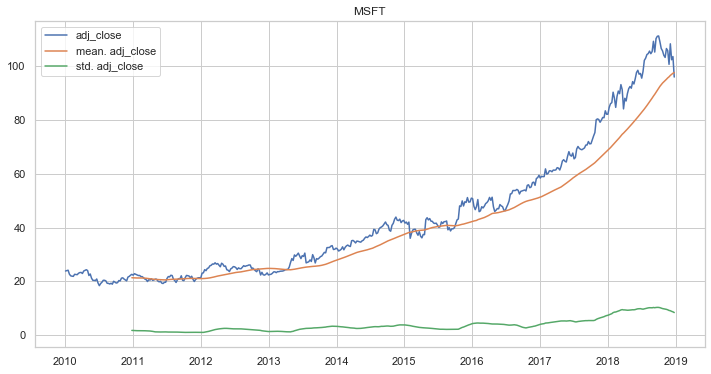

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Y_train.index, Y_train, label='adj_close')
ax.plot(Y_train.index, msft_mean, label='mean. adj_close')
ax.plot(Y_train.index, msft_std, label='std. adj_close')
ax.set_title(ticker)
ax.legend()
plt.show()

We can obviously see the mean and variance is not constant overtime, there is trend and also change in variance. It should be handle later for using statistical time series analysis.

### Decompose Time Series

Next, we can breakdown the time series into their component. So we can better understand the time series.

In [90]:
from statsmodels.tsa.seasonal import STL

stl = STL(Y_train)
seasonal = stl.fit()

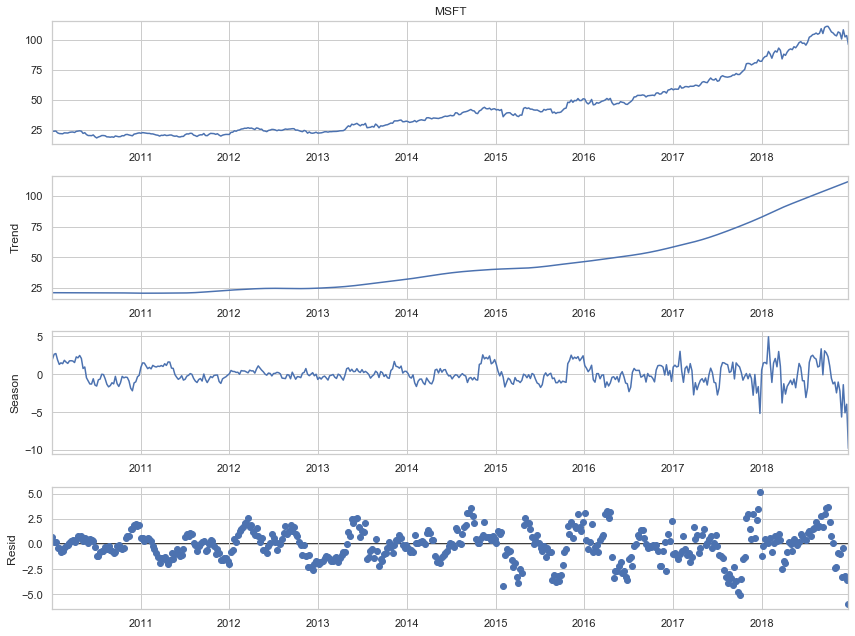

In [91]:
plt.rcParams['figure.figsize'] = (12, 9)
fig = seasonal.plot()
plt.show()

## Data Preparation

### Making the Series Time Series Stationary

**differencing**

In [92]:
def adfuller_test(series, window=12, *args, **kwargs):
    
    # plot time series
    ax = series.plot(**kwargs)
    series.rolling(window=window).mean().plot(ax=ax)
    series.rolling(window=window).std().plot(ax=ax)
    
    labels = ['Test Statistic', 'P-value', 'usedlag', 'nobs']

    result = adfuller(series, *args)
    result_df = pd.DataFrame.from_records([*zip(labels, result[:4])], 
                                          columns=['type', 'value'])
    result_df.set_index('type', inplace=True)

    for k, v in result[4].items():
        result_df.loc[k] = v

    result_df.loc["IC"] = result[-1]
    
    return result_df, ax

In [93]:
msft_diff = Y_train.diff(periods=1).dropna() 
msft_log_diff = np.log(Y_train).diff(periods=1).dropna() 

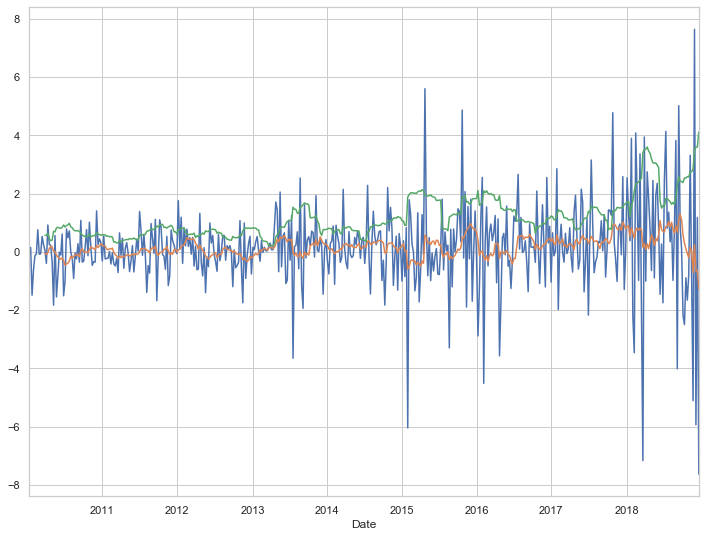

value
type                       
Test Statistic   -25.849300
P-value            0.000000
usedlag            0.000000
nobs             467.000000
1%                -3.444431
5%                -2.867749
10%               -2.570077
IC              1598.928137

In [94]:
result_df, ax = adfuller_test(msft_diff)
plt.show()
display(result_df)
# fig, ax = plt.subplots(2, sharex=True)
# msft.plot(title = f"{ticker}'s stock price", ax=ax[0])
# msft_diff.plot(ax=ax[1], title='First Differences');

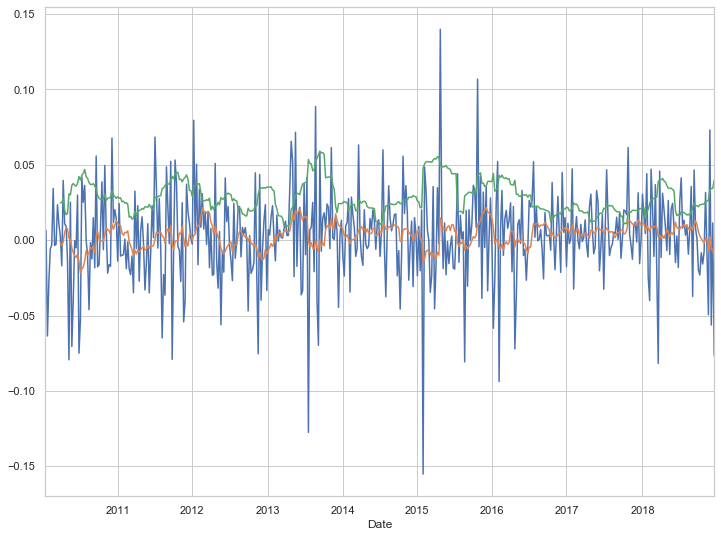

value
type                       
Test Statistic   -24.241388
P-value            0.000000
usedlag            0.000000
nobs             467.000000
1%                -3.444431
5%                -2.867749
10%               -2.570077
IC             -1867.563462

In [95]:
result_df, ax = adfuller_test(msft_log_diff)
plt.show()
display(result_df)

In [96]:
Y = np.log(Y)

nvalid = 54
ntrain = len(Y) - nvalid

Y_train = Y.iloc[:ntrain]
Y_valid = Y.iloc[ntrain:] 

print(f"Train Start/End : {Y_train.index.min()}/{Y_train.index.max()}")
print(f"Valid Start/End : {Y_valid.index.min()}/{Y_valid.index.max()}")

Train Start/End : 2010-01-03 00:00:00/2018-12-23 00:00:00
Valid Start/End : 2018-12-30 00:00:00/2020-01-05 00:00:00


In [97]:
mask_train = Y_train.index
mask_valid = Y_valid.index

**ACF & PACF of first difference** 

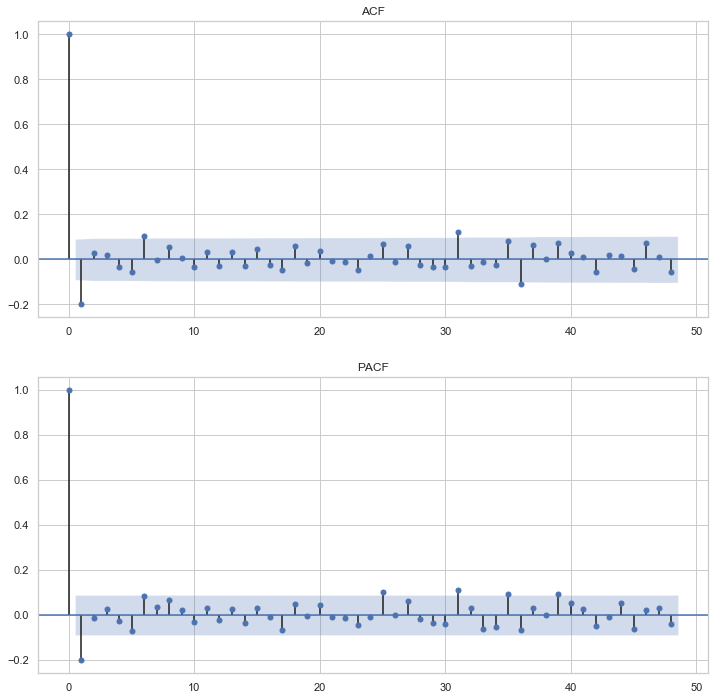

In [98]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(msft_diff, lags=48, ax=axs[0])
plot_pacf(msft_diff, lags=48, ax=axs[1])
axs[0].set_title('ACF')
axs[1].set_title('PACF')
plt.show()

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(msft_log_diff, lags=48, ax=axs[0])
plot_pacf(msft_log_diff, lags=48, ax=axs[1])
axs[0].set_title('ACF')
axs[1].set_title('PACF')
plt.show()

Nice, by taking the log first difference we have a stationary time series. therefore we can fetch it to ARMA or ARIMA model later.  

compare to directly using the stock price, it seems it's better to transform to its log form first. 

## Modeling

### Naive Modeling  

We can take a base model by doing naive modeling.   
In this case I will take the last value as the prediction for naive modeling.  

Later in the modeling part we should create a better model than naive one.

In [100]:
def rmse(y_true, y_pred, *args, **kwargs):
    return np.sqrt(mean_squared_error(y_true, y_pred, *args, **kwargs))

def eval_sample(y_actual, prediction, mask_train, mask_valid):
    rmse_train = rmse(y_actual[mask_train], prediction[mask_train])
    rmse_valid = rmse(y_actual[mask_valid], prediction[mask_valid])
    return rmse_train, rmse_valid

In [101]:
def eval_summarize(y_true, y_preds, labels, mask_train, mask_valid):
    eval_summary = pd.DataFrame(index=labels,
                                columns=['train', 'valid'])
    for i, y_pred in enumerate(y_preds):
        rmse_train, rmse_valid = eval_sample(y_true, y_pred, mask_train, mask_valid)
        eval_summary.iloc[i, 0] = rmse_train
        eval_summary.iloc[i, 1] = rmse_valid
        
    return eval_summary

In [102]:
indices = pd.date_range(start=Y_valid.index.min(), 
                        end=Y_valid.index.max(),
                        freq='W')

prediction_naive = pd.DataFrame(index=indices)
prediction_naive['naive'] = Y_valid.shift(1)
prediction_naive.iloc[0] = Y_train.iloc[-1]

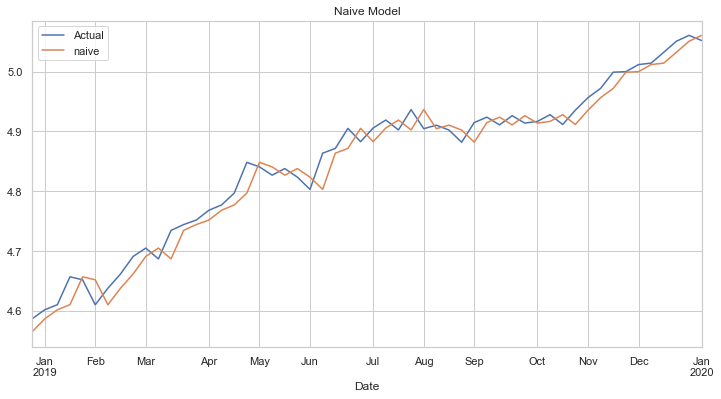

In [103]:
ax = Y_valid.plot(title='Naive Model', figsize=(12, 6), label='Actual', legend=True)
prediction_naive.plot(label='Naive', ax=ax, legend=True)
ax.axvline(x=Y_valid.index.min(), color='r', linestyle='--');

In [104]:
# valid RMSE
mask_valid = Y_valid.index
rmse_valid = rmse(Y_valid, prediction_naive.loc[mask_valid])

print("RMSE Naive Valid:", rmse_valid)

RMSE Naive Valid: 0.022925086362443902


### ARIMA

##### Manual Order Selection

In [106]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

In [107]:
model = auto_arima(
    Y_train, 
    m=1,
    seasonal=True,
    information_criterion='aic',
    maxiter=1000,
    random_state=42,
    enforce_stationarity=True,
    enforce_invertibility=True,
    suppress_warnings=True
)

In [108]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  469
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 975.601
Date:                Sun, 04 Oct 2020   AIC                          -1945.202
Time:                        12:18:11   BIC                          -1932.757
Sample:                             0   HQIC                         -1940.305
                                - 469                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.001      2.418      0.016       0.001       0.005
ma.L1         -0.1254      0.047     -2.676      0.007      -0.217      -0.034
sigma2         0.0009   3.78e-05     23.942      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       30.63   Jarque-Bera (JB):               211.44
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.43
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 0; d = 1; q = 1
order = (p, d, q)
seasonal_order = (0, 0, 0, 52)
model = SARIMAX(Y_train, 
                order=order,
                seasonal_order=seasonal_order,
                trend='c'
               )

model_result = model.fit()

In [145]:
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   MSFT   No. Observations:                  469
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 975.601
Date:                Sun, 04 Oct 2020   AIC                          -1945.202
Time:                        12:29:42   BIC                          -1932.757
Sample:                    01-03-2010   HQIC                         -1940.305
                         - 12-23-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.001      2.418      0.016       0.001       0.005
ma.L1         -0.1254      0.047     -2.676      0.007      -0.217      -0.034
sigma2         0.0009   3.78e-05     23.942      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       30.63   Jarque-Bera (JB):               211.44
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.43
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There is a slight deviation on Q-Q plot and on residual as well the variance seems changing over time, the most recent data have a higher residual. the histogram show us the mean is slightly more than 0 means our prediction could be positively bias. the correlation plot show us there is no correlated among the residual means all the order and seasonal order already handled.

Let's see the performance compare to actual data. this can be considered as evaluation

In [146]:
insample_prediction = model_result.fittedvalues[1:]

prediction = model_result.get_forecast(steps=len(Y_valid)).summary_frame()
prediction_mean = prediction['mean']

lower_ci = prediction.iloc[:, -2]
upper_ci = prediction.iloc[:, -1]

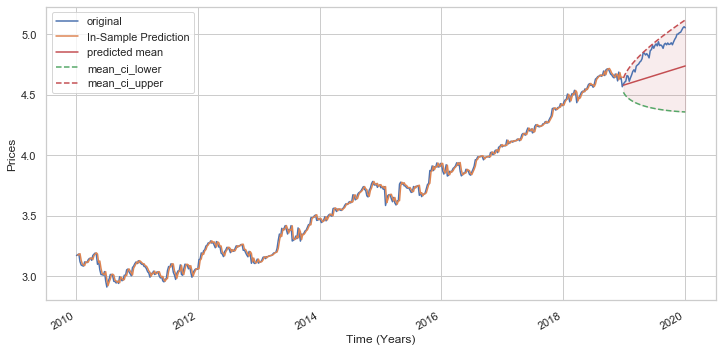

In [147]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Y.index, Y, label='original')
ax.plot(Y_train.index[1:], insample_prediction, label='In-Sample Prediction')
ax.plot(Y_valid.index, prediction_mean, color='r', label='predicted mean')
prediction[['mean_ci_lower', 'mean_ci_upper']].plot(ax=ax, style=['--', '--'],
                   label='predicted/forecasted')
ax.fill_between(prediction_mean.index, lower_ci, upper_ci, color='r', alpha=.1)
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

In [148]:
model_result.plot_diagnostics();

As we can see that our prediction on train data is fitted very well but on validation data there are more error, this one is expected but we should check the measure of the error if the gap is too high (can be considered as over-fitted).

In [149]:
train_rmse = rmse(Y_train[1:], insample_prediction)
valid_rmse = rmse(Y_valid, prediction_mean)

print("Train RMSE:", train_rmse)
print("Valid RMSE:", valid_rmse)

Train RMSE: 0.030089673757865174
Valid RMSE: 0.21011840581766236


In [150]:
model_result.save('ARIMA_011.pkl', remove_data=False)

In [151]:
from statsmodels.tsa.arima.model import ARIMAResults

model_result = ARIMAResults.load('ARIMA_011.pkl')
# arima_011.summary()

In [152]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.extend.html

history = Y_train.copy()
predictions = []

for t in range(len(Y_valid)):
    model_result = model_result.extend(Y_valid.iloc[[t]])
    output = model_result.get_forecast(steps=1).summary_frame()
    yhat = output
    predictions.append(yhat)

predictions = pd.concat(predictions)

In [153]:
prediction_mean = predictions['mean']
lower_ci = predictions.iloc[:, -2]
upper_ci = predictions.iloc[:, -1]

In [154]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Y.index, Y, label='original')
ax.plot(Y_valid.index, prediction_mean, color='r', label='predicted mean')
predictions[['mean_ci_lower', 'mean_ci_upper']].plot(ax=ax, style=['--', '--'],
                   label='predicted/forecasted')
ax.fill_between(prediction_mean.index, lower_ci, upper_ci, color='r', alpha=.1)
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

it is like too good to be true, let we check wether the updated model forecasting the same date on new input given or not. 

In [155]:
model_check = ARIMAResults.load('ARIMA_011.pkl')
print("last data in the model before adding new input")
print(model_check.data.dates[-1], model_check.fittedvalues[-1])
model_check = model_check.extend(Y_valid.iloc[[0]])
print("last data in the model after adding new input")
print(model_check.data.dates[-1], model_check.fittedvalues[-1])
print("new input given")
print(Y_valid.iloc[[0]])
print("forecasted value")
print(model_check.forecast(steps=1))
print("the date that we want to predict")
print(Y_valid.iloc[[1]])
print("="*20)
print(Y_valid.iloc[[0]].index == model_check.forecast(steps=1).index)

last data in the model before adding new input
2018-12-23 00:00:00 4.643861017310911
last data in the model after adding new input
2018-12-30 00:00:00 4.577633130976841
new input given
Date
2018-12-30    4.586462
Freq: W-SUN, Name: MSFT, dtype: float64
forecasted value
2019-01-06    4.588351
Freq: W-SUN, dtype: float64
the date that we want to predict
Date
2019-01-06    4.601685
Freq: W-SUN, Name: MSFT, dtype: float64
[False]


In [156]:
valid_rmse = rmse(Y_valid, predictions['mean'])

print("Valid RMSE 1-Step:", valid_rmse)

Valid RMSE 1-Step: 0.003356963701017764


In [157]:
naive = Y_valid.shift(1)
naive.iloc[0] = Y_train.iloc[-1]

In [158]:
# compare to naive model 1-step ahead
naive_valid_rmse = rmse(Y_valid, naive)
print("Valid RMSE 1-Step:", naive_valid_rmse)

Valid RMSE 1-Step: 0.022925086362443902


By doing one step ahead by extending / refitting the model with new data to forecast one step ahead is much better than forecasting several step ahead.  

### FB Prophet

Facebook prophet need input in type of dataframe with `ds` as date with pandas.datetime format and `y` is value with type float. 

first, we have to transform our data into this format.

In [159]:
fb_Y = Y.reset_index()
fb_Y.columns = ['ds', 'y']
fb_Y.head()

ds         y
0 2010-01-03  3.169747
1 2010-01-10  3.175635
2 2010-01-17  3.182137
3 2010-01-24  3.118592
4 2010-01-31  3.091289

In [160]:
nvalid = 54
ntrain = len(Y) - nvalid

fb_Y_train = fb_Y.iloc[:ntrain]
fb_Y_valid = fb_Y.iloc[ntrain:]

In [161]:
model = Prophet()
model = model.fit(fb_Y_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [162]:
fb_prediction = model.make_future_dataframe(periods=len(fb_Y_valid),
                                            freq='W',
                                            include_history=True)

In [163]:
fb_prediction = model.predict(fb_prediction)
fb_prediction.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
518 2019-12-08  5.073246    4.960360    5.189471     4.982760     5.166146   
519 2019-12-15  5.079897    4.976048    5.199696     4.985247     5.173881   
520 2019-12-22  5.086547    4.965916    5.192384     4.988434     5.183998   
521 2019-12-29  5.093197    4.978032    5.208726     4.992610     5.194602   
522 2020-01-05  5.099847    4.980826    5.233470     4.996293     5.204601   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
518        0.000264              0.000264              0.000264  0.000264   
519        0.002293              0.002293              0.002293  0.002293   
520        0.002437              0.002437              0.002437  0.002437   
521        0.004796              0.004796              0.004796  0.004796   
522        0.011676              0.011676              0.011676  0.011676   

     yearly_lower  yearly_upper  multiplicative_terms  \
518      0.000264      0.000264                   0.0   
519      0.002293      0.002293                   0.0   
520      0.002437      0.002437                   0.0   
521      0.004796      0.004796                   0.0   
522      0.011676      0.011676                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
518                         0.0                         0.0  5.073511  
519                         0.0                         0.0  5.082190  
520                         0.0                         0.0  5.088984  
521                         0.0                         0.0  5.097993  
522                         0.0                         0.0  5.111523

In [164]:
model.plot_components(fb_prediction, 
                      figsize=(12, 12));

In [165]:
from fbprophet.models import pickle

filename = "fbprophet.pickle"

with open(filename, "wb") as f:
    pickle.dump(model, f)

In [166]:
filename = "fbprophet.pickle"

with open(filename, "rb") as f:
    model = pickle.load(f)

In [167]:
fb_prediction.set_index('ds', inplace=True)

In [168]:
plt.figure(figsize=(12, 6))

ax = Y.plot(label='actual')
fb_prediction[['yhat_lower', 'yhat_upper']].plot(ax=ax, 
                   style=['--', '--'],
                   label='predicted/forecasted')
fb_prediction['yhat'].plot(ax=ax, color='r', style='.', label='predicted mean')
ci_index = fb_prediction.index
lower_ci = fb_prediction.loc[:, 'yhat_lower']
upper_ci = fb_prediction.loc[:, 'yhat_upper']

ax.fill_between(ci_index, lower_ci, upper_ci, color='r', alpha=.1)
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

In [169]:
mask_train = Y_train.index
mask_valid = Y_valid.index

prediction_list = [fb_prediction['yhat']]

labels = ['facebook prophet']

eval_prophet = eval_summarize(Y, prediction_list, labels, mask_train, mask_valid)
eval_prophet

train      valid
facebook prophet  0.049036  0.0858838

##### Daily update scenario

In [170]:
import warnings

warnings.filterwarnings("ignore")

In [171]:
history = fb_Y_train.copy()
predictions = []

for t in range(len(Y_valid)):
    model = Prophet()
    model.fit(history)
    
    fb_prediction = model.make_future_dataframe(periods=1,
                                                freq='W',
                                                include_history=False)
    
    fb_prediction = model.predict(fb_prediction)
    predictions.append(fb_prediction)
    obs = fb_Y_valid.iloc[t]
    history = history.append(obs)

predictions = pd.concat(predictions).set_index('ds')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

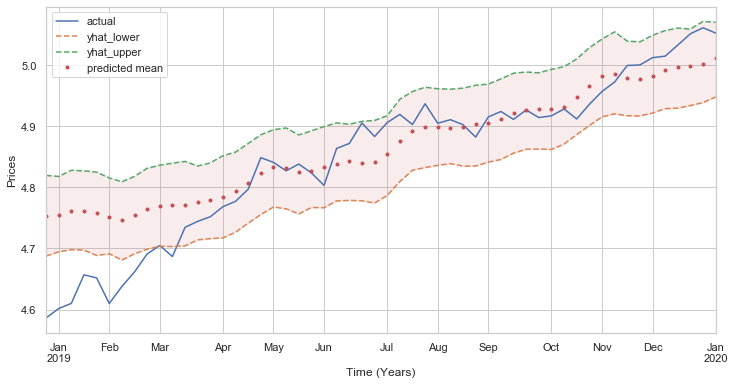

In [172]:
plt.figure(figsize=(12, 6))

ax = Y_valid.plot(label='actual')
predictions[['yhat_lower', 'yhat_upper']].plot(ax=ax, 
                   style=['--', '--'],
                   label='predicted/forecasted')
predictions['yhat'].plot(ax=ax, color='r', style='.', label='predicted mean')
ci_index = predictions.index
lower_ci = predictions.loc[:, 'yhat_lower']
upper_ci = predictions.loc[:, 'yhat_upper']

ax.fill_between(ci_index, lower_ci, upper_ci, color='r', alpha=.1)
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

In [173]:
mask_valid = Y_valid.index

prediction_list = [predictions['yhat']]

labels = ['facebook prophet']

eval_prophet = eval_summarize(Y_valid, prediction_list, labels, mask_valid, mask_valid)
eval_prophet

train      valid
facebook prophet  0.0591004  0.0591004

In [174]:
rmse(Y_valid, naive)

0.022925086362443902